In [6]:
%%latex

w = 2

<IPython.core.display.Latex object>

# Conditioning a Gaussian distribution on a system of linear equations

## The problem

Conditioning a multivariate Gaussian on partial observations is notoriously simple, especially in the canonical parametrization.  Given

$$
\w = 2
$$

we can condition on an observed subvector $x_2$ and obtain a posterior distribution on the unobserved variables $x_1$

$$
pr\left( x_1 cond x_2 \right) = NN\left[ A_{11}, b_1 - A_{12} x_2 \right] \,.
$$

However, this assumes that the observations are aligned with the predefined axes.  How do we condition on a general system of linear equations?

$$
pr(x ~|~  Cx = d)
$$

## The solution

Let $x\sim\ NN[A, b]$ be a $d$-dimensional random variable, and let there be a system of $k$ linear equations $Cx = d$, where $C\in R^{k \times d}$ and $d\in R^k$.

The system of linear equations $Cx = d$ has solutions $x^\star = C PI d +w$, where $w\in null C$.  The $C PI d$ component is that which is fixed by the constraints, whereas the $w$ is a free variable which only spans a $(d-k)$-dimensional latent subspace.  Because $w\in null C$, and given the SVD of $C = U S V^T$, we know that

$$
w = V_\perp \underbrace{V_\perp^T w}_z \,,
$$

where $z = V_\perp^T w$ is the $(d-k)$-dimensional free variable in latent space.  

Let us take the canonical Gaussian neg-log likelihood and first apply the system solution $x^\star$,


Let's implement this to verify that it is indeed the correct solution.

In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd

from scipy.stats import multivariate_normal

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas

In [2]:
class ConditionableGaussian(object):
    def __init__(self, S, m):
        """ Initialize Gaussian parameters N(m, S) """
        
        # Canonical parametrization  of Gaussian rules
        self.A = la.inv(S)
        self.b = np.dot(self.A, m)
        self.x_rv = multivariate_normal(mean=m, cov=S)
    
    def condition(self, C, d):
        """ Condition Gaussian on Cx = d """
        
        # Quantities needed to sample in latent space and embed back in ambient space
        U, S, V = la.svd(C, full_matrices=1)
        r = len(S)
        self.V_orth = V[r:, :].T

        CPI = la.pinv(C)
        self.CPId = np.dot(CPI, d)
        
        # Conditional Gaussian params in latent space
        Az = la.multi_dot([self.V_orth.T, self.A, self.V_orth])
        bz = np.dot(self.V_orth.T, self.b - np.dot(self.A, self.CPId))
        Sz = la.inv(Az)
        mz = np.dot(Sz, bz)
        self.z_rv = multivariate_normal(mean=mz, cov=Sz)
        
        
    def sample_prior(self, n):
        """ Sample from prior N[A, b] """
        return self.x_rv.rvs(size=n).reshape((n, -1))
        
    def sample_latent(self, n):
        """ Sample from latent space non-singular distribution """
        return self.z_rv.rvs(size=n).reshape((n, -1))

    def embed(self, Z):
        """ Embed latent variables into ambient space """
        return np.dot(Z, self.V_orth.T) + self.CPId
        
    def sample_posterior(self, n):
        """ Sample from posterior N[A, b] | Cx = d] """
        Z = self.sample_latent(n)
        return self.embed(Z)

In [3]:
ndim = 3

# Random gaussian distribution
S = np.triu(rnd.uniform(-1, 1, (ndim, ndim)))
S = np.dot(S, S.T)
m = np.zeros(ndim)


# Set your own constraints M = [C, d] ...
M = np.array([
    [1, -1, 0, 0],
    [0, 1, 1, 0]
])

# ... or use random ones
ncons = 1
M = rnd.uniform(-1, 1, (ncons, ndim+1))

C = M[:, :-1]
d = M[:, -1].ravel()

cg = ConditionableGaussian(S, m)
cg.condition(C, d)

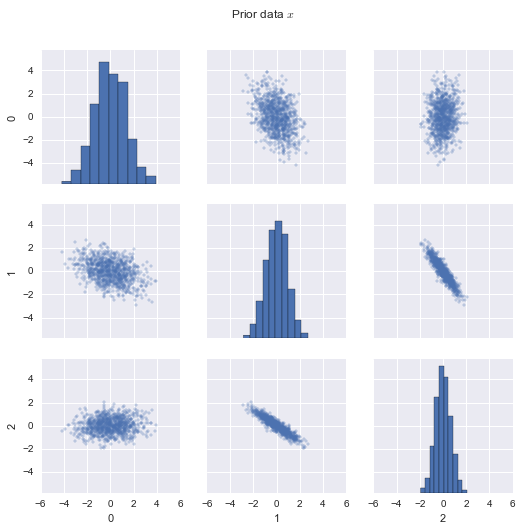

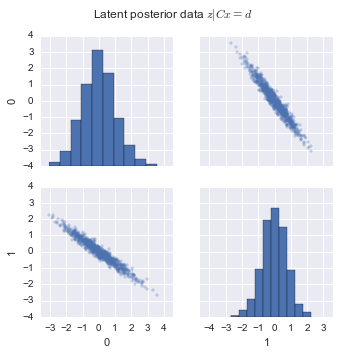

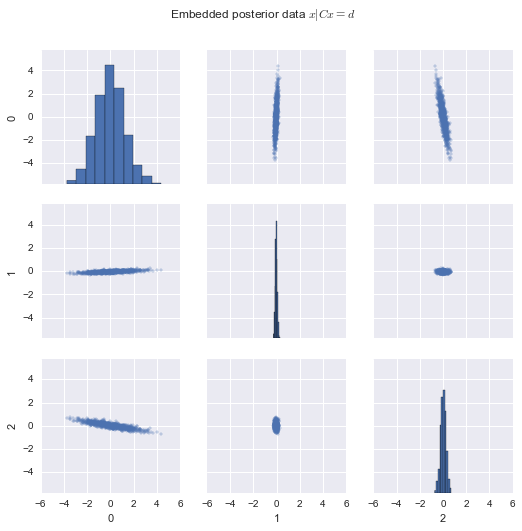

In [4]:
def pairplot(data, title):
    df = pandas.DataFrame(data)
    pp = sns.pairplot(df, markers='+')
    
    pp.set(aspect = 'equal')
    plt.subplots_adjust(top=.9)
    sns.plt.suptitle(title)

ndata = 1000

# Analytical prior, latent and posterior samples
X_prior = cg.sample_prior(ndata)
Z = cg.sample_latent(ndata)
X_post = cg.embed(Z)

pairplot(X_prior, 'Prior data $x$')
pairplot(Z, 'Latent posterior data $z|Cx=d$')
pairplot(X_post, 'Embedded posterior data $x|Cx=d$')

## Verification via rejection sampling

To verify that the posterior data is sampled from the correct distribution, we compare it to approximate data sampled using rejection sampling.  The data is obtained by sampling from the prior distribution and accepting if $\| Cx-d \|_\infty < 0.01$.  If our solution is correct, the data graphs should look similar.

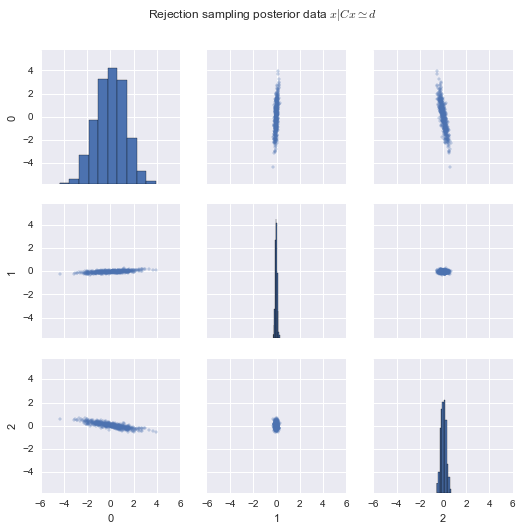

In [5]:
ndata = 500

# Rejection sampling posterior samples
n = 0
X_post_rej = []
while n < ndata:
    X = cg.sample_prior(ndata)
    CXmd = np.dot(C, X.T) - d[:, np.newaxis]
    accepted = la.norm(CXmd, np.inf, axis=0) < .01
    X_post_rej.append(X[accepted, :])
    n += accepted.sum()
X_post_rej = np.vstack(X_post_rej)

# NOTE that the more constraints the are, the less similar the graphs will be
pairplot(X_post_rej, 'Rejection sampling posterior data $x | Cx \simeq d$')